In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

$$\dot{S} = -\beta S Z $$ 
$$\dot{Z} = (\beta - \kappa) S Z $$
$$\dot{R} = \kappa S Z $$


$$\alpha = \kappa / \beta$$

In [3]:
def SZR_dot(S, Z, R, b, k):
    return np.array([-b*S*Z, (b-k)*S*Z, k*S*Z])

b = 1
k = 0.6

S_0 = 199
Z_0 = 1
R_0 = 0

SZR = np.array([[S_0, Z_0, R_0]])

dt = 0.0001

for i in range(2000):
    
    SZR = np.append(SZR, [SZR[-1,:] + SZR_dot(SZR[-1,0],SZR[-1,1], SZR[-1,2], b, k)*dt], axis = 0)

<IPython.core.display.Javascript object>


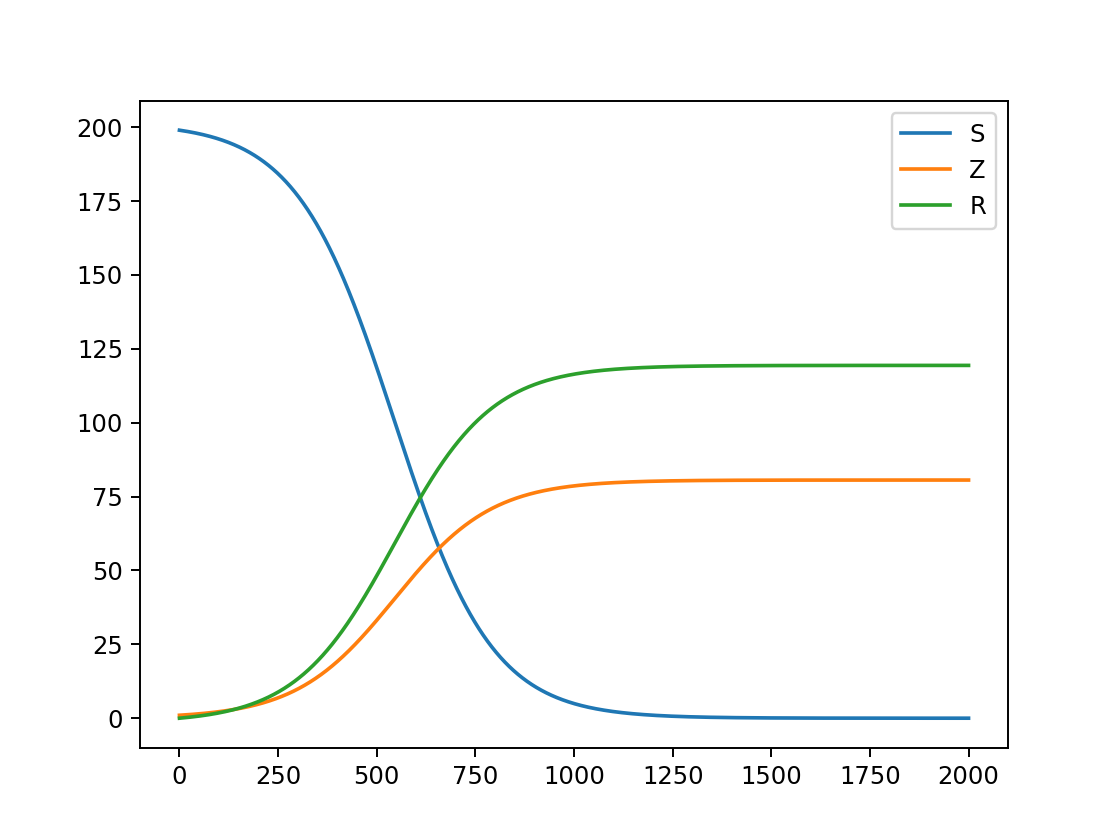

In [4]:
plt.plot(SZR[:,0], label = "S")
plt.plot(SZR[:,1], label = "Z")
plt.plot(SZR[:,2], label = "R")
plt.legend()

Gillespie algorithm

$$p(\tau, j| \vec{x}, t) = a_{j}(\vec{x}) e^{-\tau \Sigma_{j}a_{j}(\vec{x})}$$\\

$$\tau = \frac{1}{\Sigma_{j}a_{j}(\vec{x})}log(\frac{1}{r_{1}})$$

In [11]:
def get_tau(S, Z, R, b, k):
    r1 = 1- np.random.uniform()
    a1 = b*S*Z
    a2 = k*S*Z
    
    return 1/(a1 + a2) * np.log(1/r1)


def get_j(S, Z, R, b, k):
    r2 = np.random.uniform()
    if r2 <  b/(b + k):
        return 0
    else:
        return 1
    
    
def update(S, Z, R, t, b, k):
    tau = get_tau(S, Z, R, b, k)
    t_new = t + tau
    if get_j(S, Z, R, b, k) == 0:
        S_new = S - 1
        Z_new = Z + 1
        R_new = R
    else:
        S_new = S
        Z_new = Z - 1
        R_new = R + 1
        
    return S_new, Z_new, R_new, t_new


S_0 = 199
Z_0 = 1
R_0 = 0

SZR = np.array([[S_0, Z_0, R_0]])

b = 1
k = 0.6
t = [0]

for i in range(4000):
    
    S_n, Z_n, R_n, t_n = update(SZR[-1, 0], SZR[-1, 1], SZR[-1, 2], t[-1], b, k)
    
    SZR = np.append(SZR, [[S_n, Z_n, R_n]], axis = 0)
    t.append(t_n)

<ipython-input-11-e0b6b24cba34>:6: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/(a1 + a2) * np.log(1/r1)


<IPython.core.display.Javascript object>


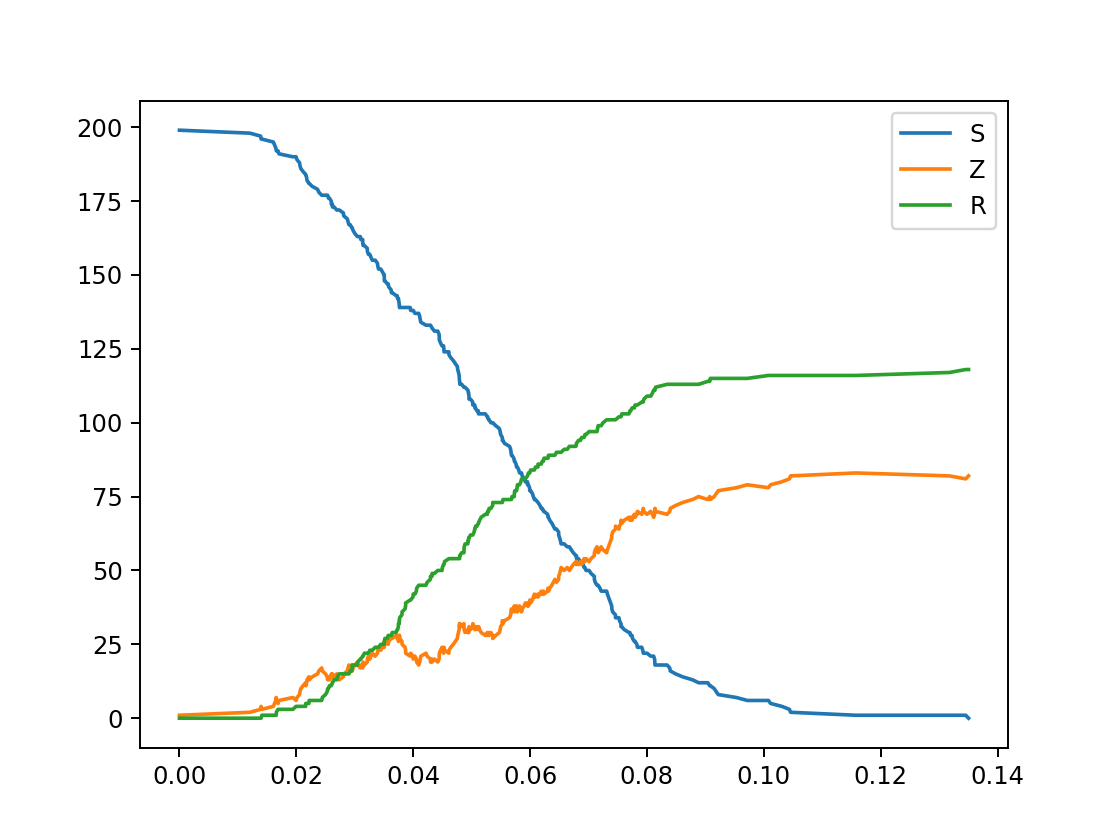

In [12]:
plt.plot(t, SZR[:,0], label = "S")
plt.plot(t, SZR[:,1], label = "Z")
plt.plot(t, SZR[:,2], label = "R")
plt.legend()

square lattice model

In [205]:
L = 64

lattice = np.zeros((L, L), dtype = int)
xy0 = (int(L/2), int(L/2))

lattice[xy0] = 1

left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
up     = lambda xy: (      xy[0], (xy[1]+1)%L)
down   = lambda xy: (      xy[0], (xy[1]-1)%L)

queue = [(xy0,  left(xy0)), 
         (xy0, right(xy0)), 
         (xy0,    up(xy0)), 
         (xy0,  down(xy0))]

k = 0.6

b = 1


def check(lattice, queue):
    counter = 0
    zlist = np.transpose(np.where(lattice == 1))
    
    for xyz in zlist:

        for xyn in left(tuple(xyz)), right(tuple(xyz)), up(tuple(xyz)), down(tuple(xyz)):
            if lattice[xyn] == 0:
                counter += 1
                if (tuple(xyz), xyn) not in queue:
                    print(tuple(xyz), xyn)
                    return False
                
    if counter == len(queue):
        return True
    else:
        print(counter, len(queue))
        return False
    

def update(lattice, queue, k, b):
    
    if len(queue) == 0:
        return lattice, queue
    
    ind = np.random.randint(len(queue))
    r = np.random.uniform()
    
    if r < b/(b + k):
        xyz, xys = queue.pop(ind)
        assert(lattice[xyz] == 1)
        assert(lattice[xys] == 0)
        lattice[xys] = 1
        
        for xyn in left(xys), right(xys), up(xys), down(xys):
            if lattice[xyn] == 0:
                queue.append((xys, xyn))
        
        if len(queue) == 0:
            return lattice, queue
        
        for xyn in left(xys), right(xys), up(xys), down(xys):
            if lattice[xyn] == 1 and xyn != xyz:
                ind = queue.index((xyn, xys))
                queue.pop(ind)
        

    else:
        xyz, xys = queue.pop(ind)
        assert(lattice[xyz] == 1)
        assert(lattice[xys] == 0)
        lattice[xyz] = 2
        
        if len(queue) == 0:
            return lattice, queue
        
        for xyn in left(xyz), right(xyz), up(xyz), down(xyz):
            if lattice[xyn] == 0 and xyn != xys:
                ind = queue.index((xyz, xyn))
                queue.pop(ind)
    
    return lattice, queue
        
         

seed = np.random.randint(1000000)
np.random.seed(seed) 

# 826678, 363713 died out
#985706, 670716, 575427 zombies trapped by corpses

SZR = {0:[], 1:[], 2:[]}

for i in range(1000):
    
    labels, counts = np.unique(lattice, return_counts = True)
    
    for j in range(len(labels)):
        SZR[labels[j]].append(counts[j])
        
        
    lattice, queue = update(lattice, queue, k, b)

    #for validation
    #if check(lattice, queue) == False:
    #    break

    


<IPython.core.display.Javascript object>


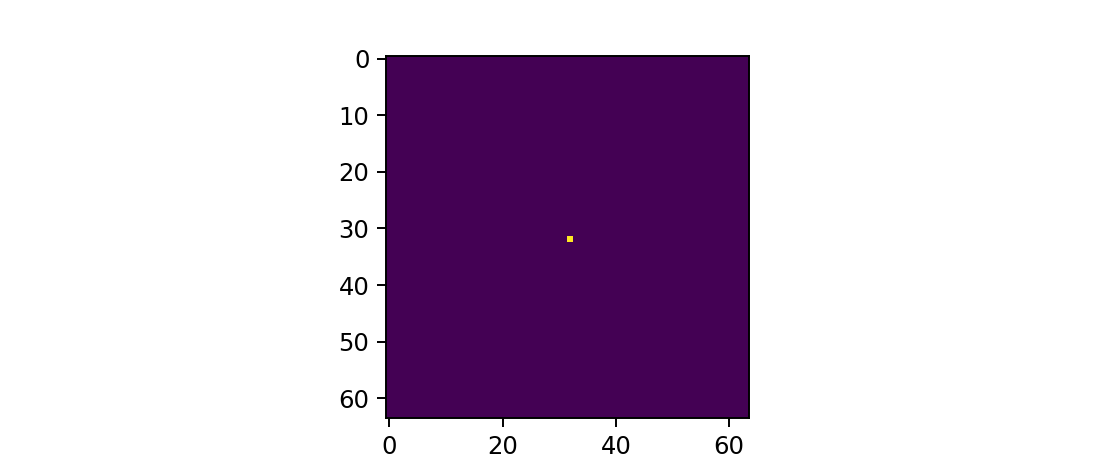

In [206]:
plt.imshow(lattice)

In [204]:
seed

575427

<IPython.core.display.Javascript object>


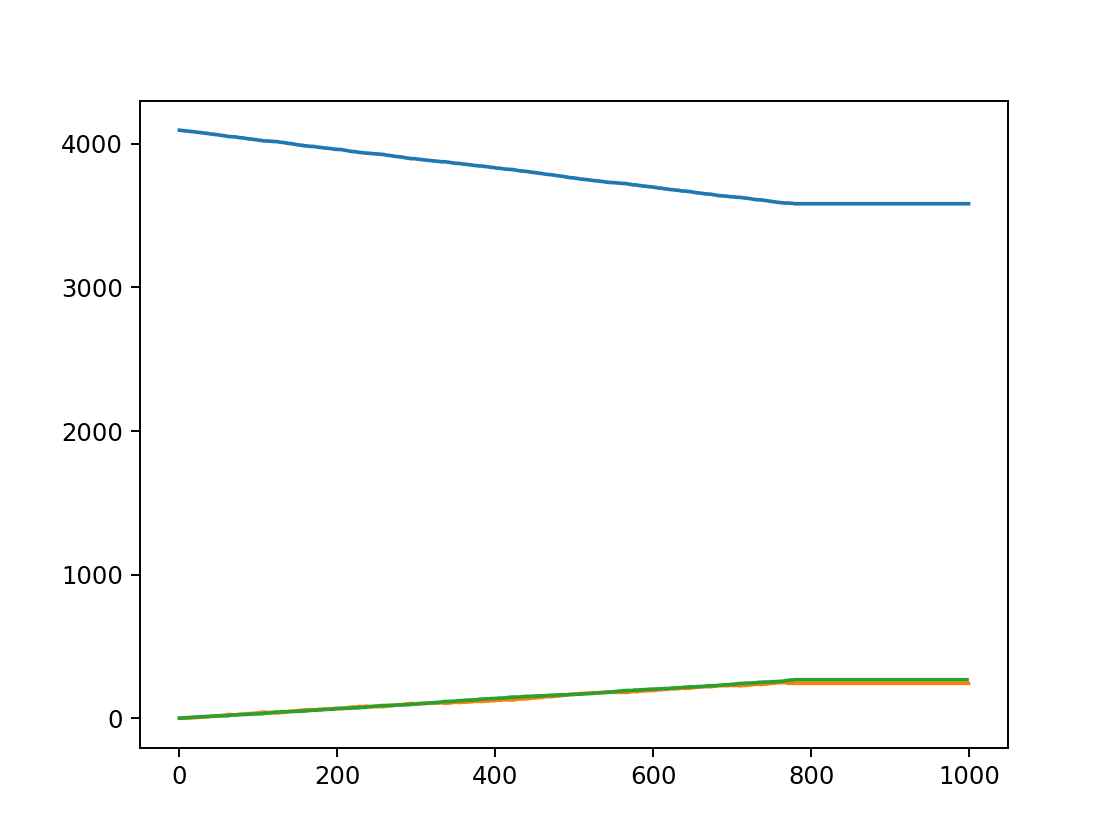

In [203]:
plt.plot(SZR[0])
plt.plot(SZR[1])
plt.plot(SZR[2])

<IPython.core.display.Javascript object>


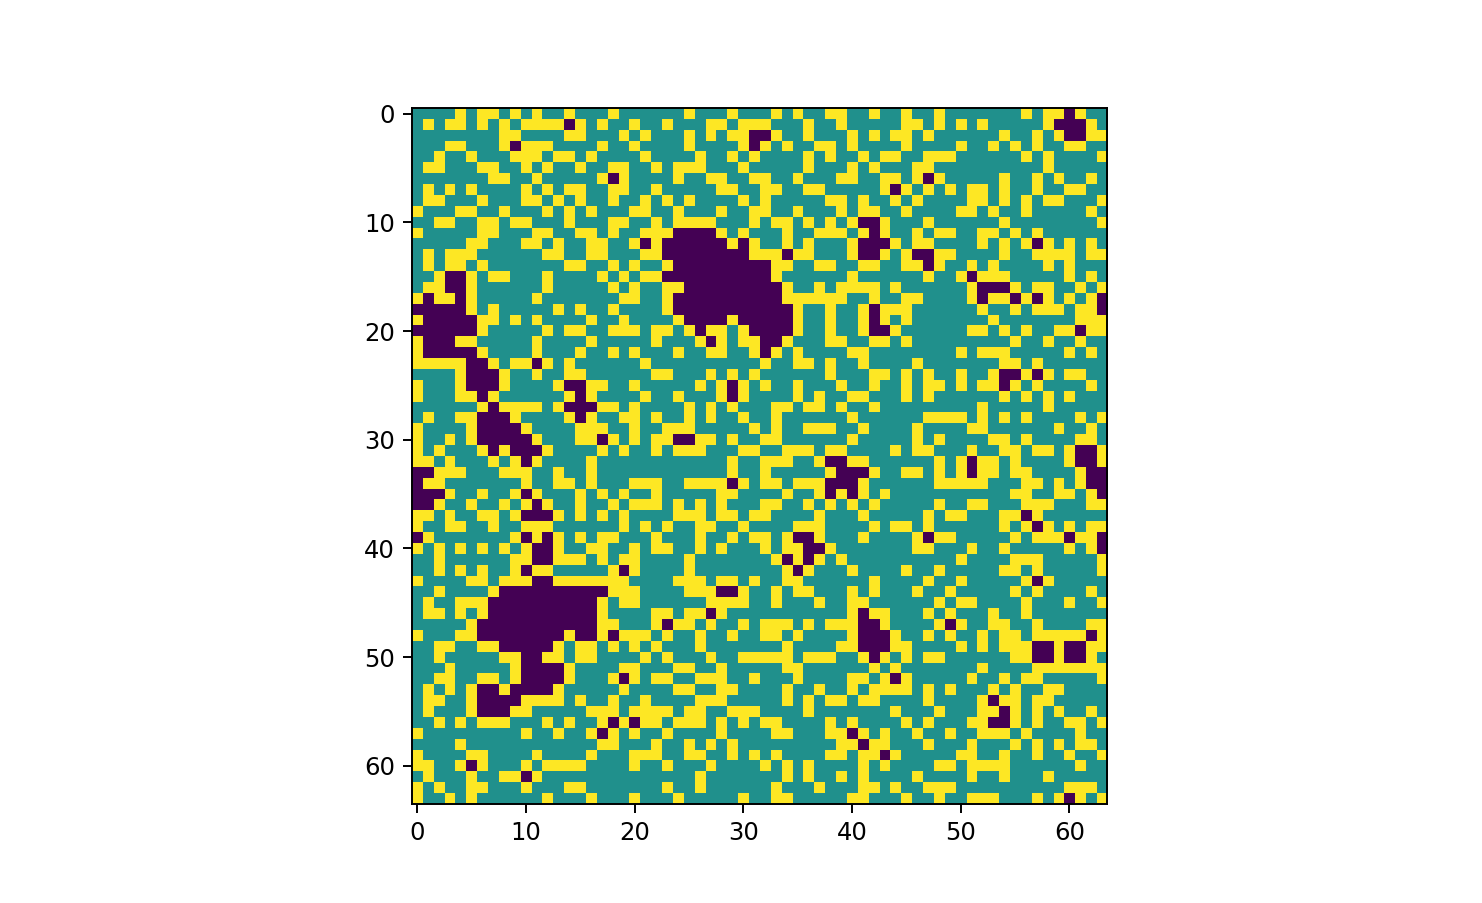

In [223]:
L = 64

lattice = np.zeros((L, L), dtype = int)
xy0 = (int(L/2), int(L/2))

lattice[xy0] = 1

left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
up     = lambda xy: (      xy[0], (xy[1]+1)%L)
down   = lambda xy: (      xy[0], (xy[1]-1)%L)

queue = [(xy0,  left(xy0)), 
         (xy0, right(xy0)), 
         (xy0,    up(xy0)), 
         (xy0,  down(xy0))]

k = 0.4

b = 1

seed = np.random.randint(1000000)
np.random.seed(seed) 

#137117, 112642

SZR = {0:[], 1:[], 2:[]}

while len(queue) != 0:
    
    labels, counts = np.unique(lattice, return_counts = True)
    
    for j in range(len(labels)):
        SZR[labels[j]].append(counts[j])
        
        
    lattice, queue = update(lattice, queue, k, b)

    #for validation
    #if check(lattice, queue) == False:
    #    break
        
plt.imshow(lattice)

<IPython.core.display.Javascript object>


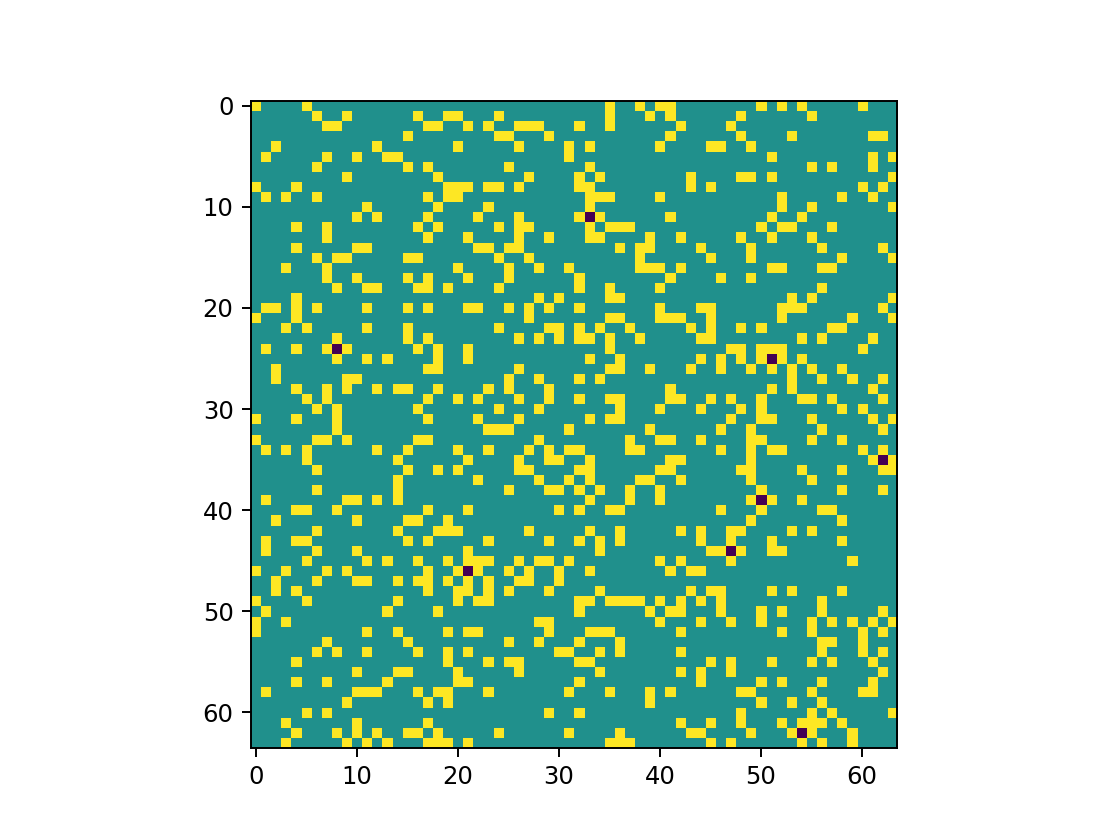

In [229]:
L = 64

lattice = np.zeros((L, L), dtype = int)
xy0 = (int(L/2), int(L/2))

lattice[xy0] = 1

left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
up     = lambda xy: (      xy[0], (xy[1]+1)%L)
down   = lambda xy: (      xy[0], (xy[1]-1)%L)

queue = [(xy0,  left(xy0)), 
         (xy0, right(xy0)), 
         (xy0,    up(xy0)), 
         (xy0,  down(xy0))]

k = 0.2

b = 1

seed = np.random.randint(1000000)
np.random.seed(seed) 

#137117, 112642

SZR = {0:[], 1:[], 2:[]}

while len(queue) != 0:
    
    labels, counts = np.unique(lattice, return_counts = True)
    
    for j in range(len(labels)):
        SZR[labels[j]].append(counts[j])
        
        
    lattice, queue = update(lattice, queue, k, b)

    #for validation
    #if check(lattice, queue) == False:
    #    break
        
plt.imshow(lattice)

<IPython.core.display.Javascript object>


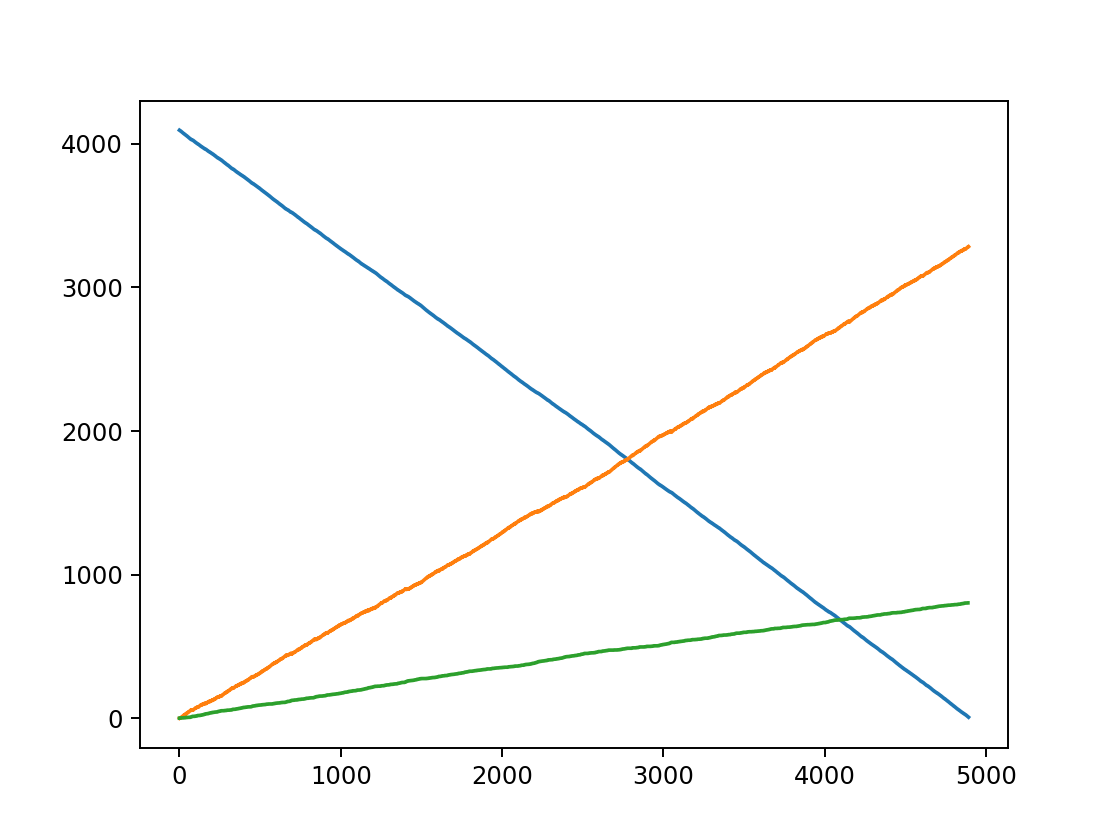

In [230]:
plt.plot(SZR[0])
plt.plot(SZR[1])
plt.plot(SZR[2])

<IPython.core.display.Javascript object>


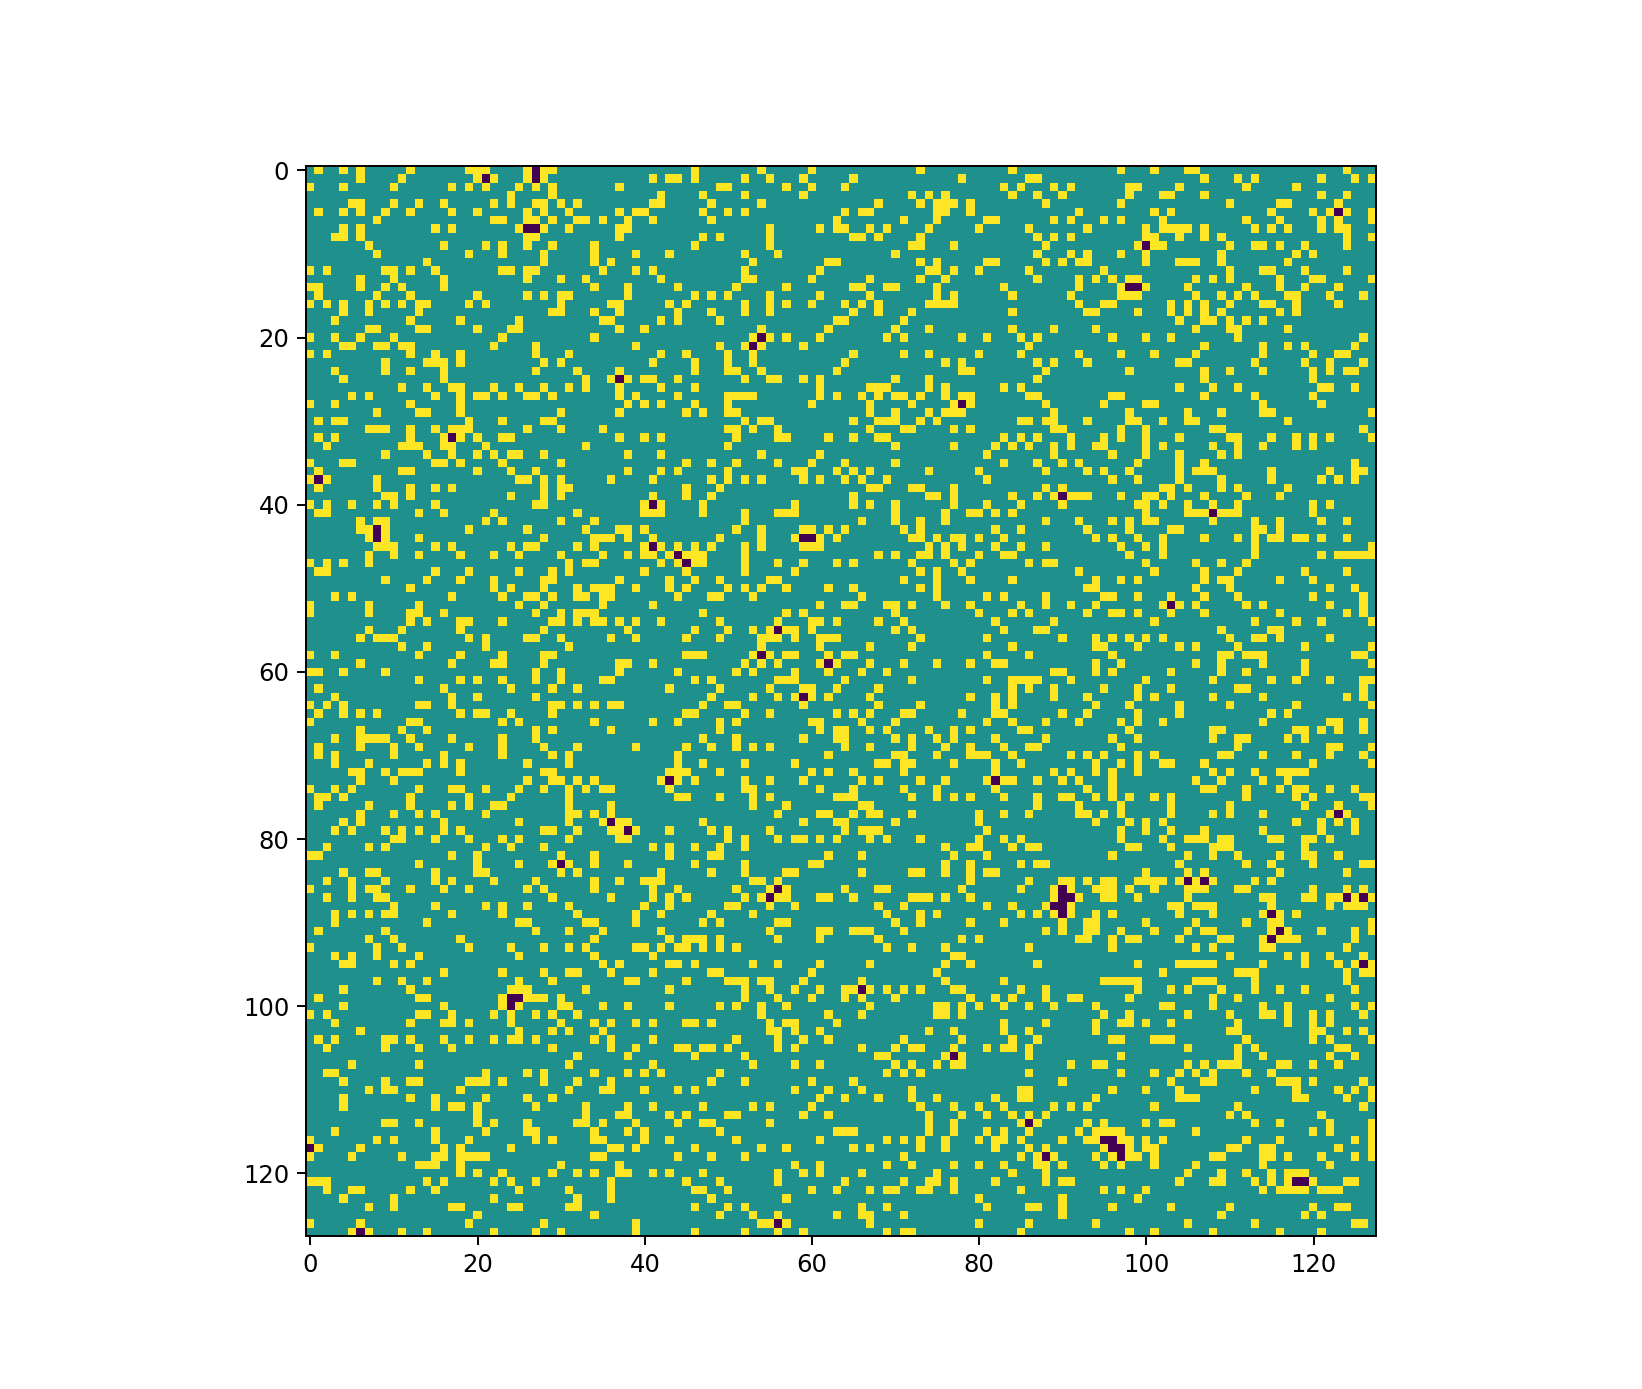

In [231]:
L = 128

lattice = np.zeros((L, L), dtype = int)
xy0 = (int(L/2), int(L/2))

lattice[xy0] = 1

left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
up     = lambda xy: (      xy[0], (xy[1]+1)%L)
down   = lambda xy: (      xy[0], (xy[1]-1)%L)

queue = [(xy0,  left(xy0)), 
         (xy0, right(xy0)), 
         (xy0,    up(xy0)), 
         (xy0,  down(xy0))]

k = 0.2

b = 1

seed = np.random.randint(1000000)
np.random.seed(seed) 

#137117, 112642

SZR = {0:[], 1:[], 2:[]}

while len(queue) != 0:
    
    labels, counts = np.unique(lattice, return_counts = True)
    
    for j in range(len(labels)):
        SZR[labels[j]].append(counts[j])
        
        
    lattice, queue = update(lattice, queue, k, b)

    #for validation
    #if check(lattice, queue) == False:
    #    break
        
plt.imshow(lattice)

<IPython.core.display.Javascript object>


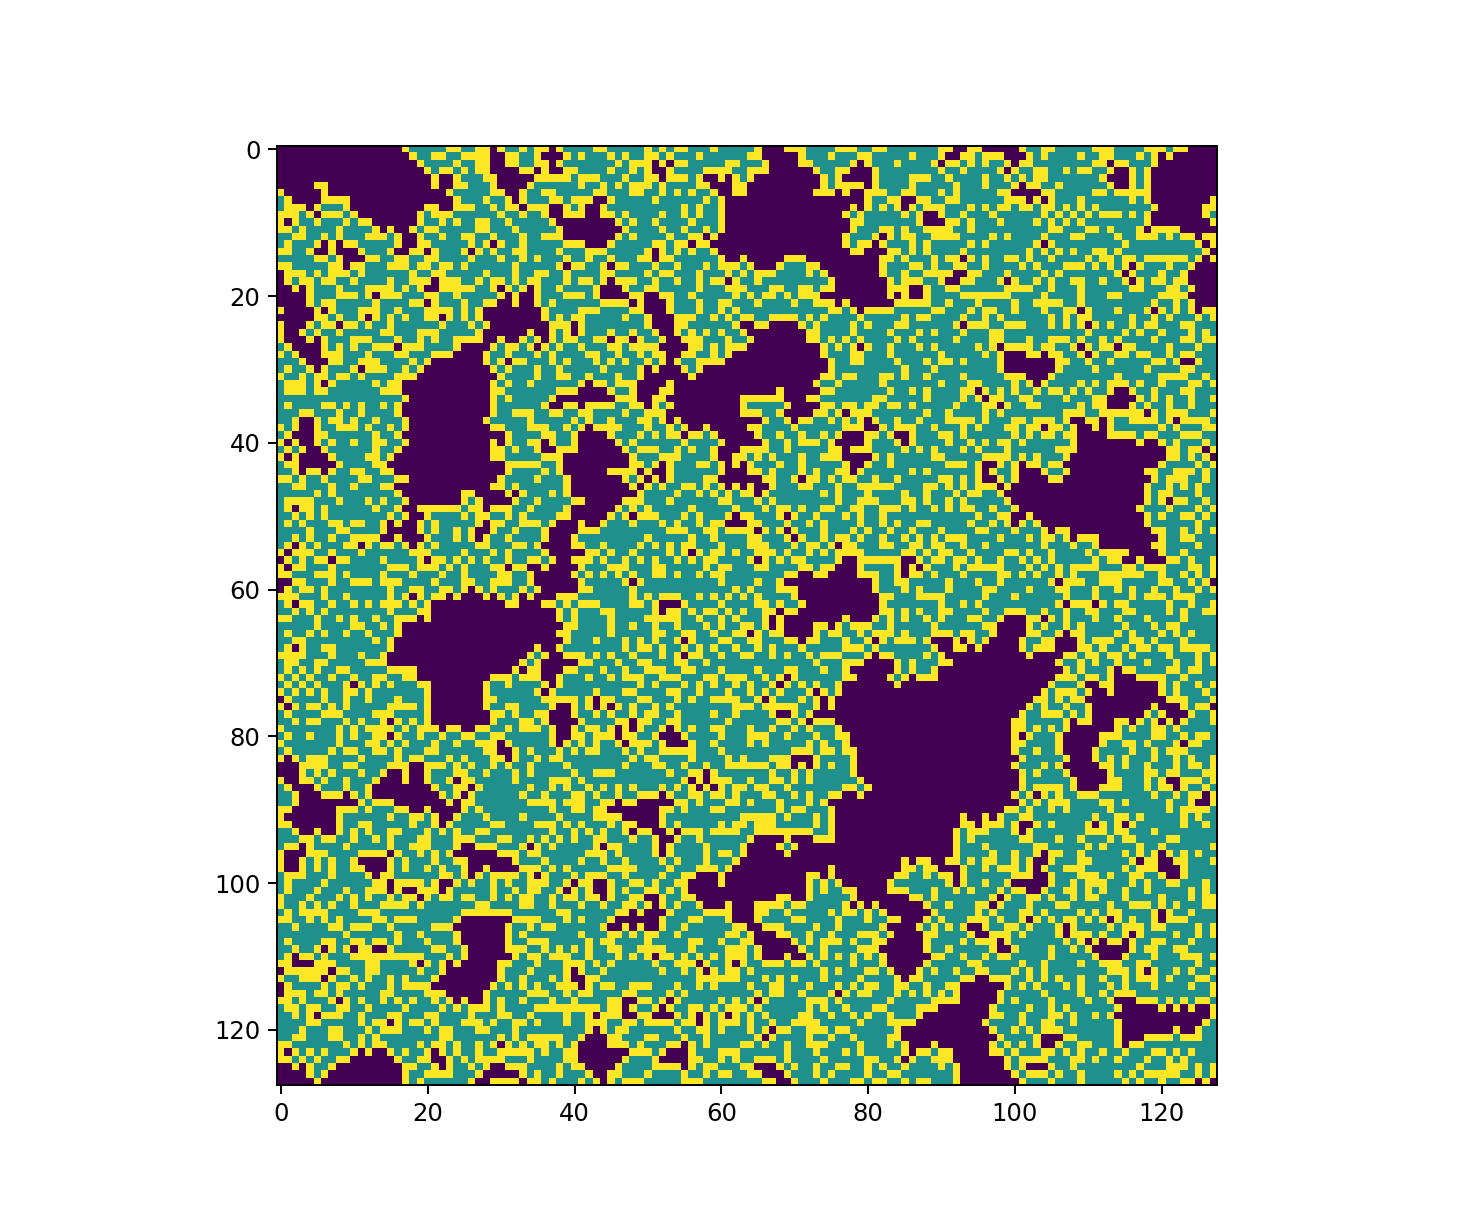

In [239]:
L = 128

lattice = np.zeros((L, L), dtype = int)
xy0 = (int(L/2), int(L/2))

lattice[xy0] = 1

left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
up     = lambda xy: (      xy[0], (xy[1]+1)%L)
down   = lambda xy: (      xy[0], (xy[1]-1)%L)

queue = [(xy0,  left(xy0)), 
         (xy0, right(xy0)), 
         (xy0,    up(xy0)), 
         (xy0,  down(xy0))]

k = 0.43

b = 1

seed = np.random.randint(1000000)
np.random.seed(seed) 

#137117, 112642

SZR = {0:[], 1:[], 2:[]}

while len(queue) != 0:
    
    labels, counts = np.unique(lattice, return_counts = True)
    
    for j in range(len(labels)):
        SZR[labels[j]].append(counts[j])
        
        
    lattice, queue = update(lattice, queue, k, b)

    #for validation
    #if check(lattice, queue) == False:
    #    break
        
plt.imshow(lattice)

61.87921214103699


<IPython.core.display.Javascript object>


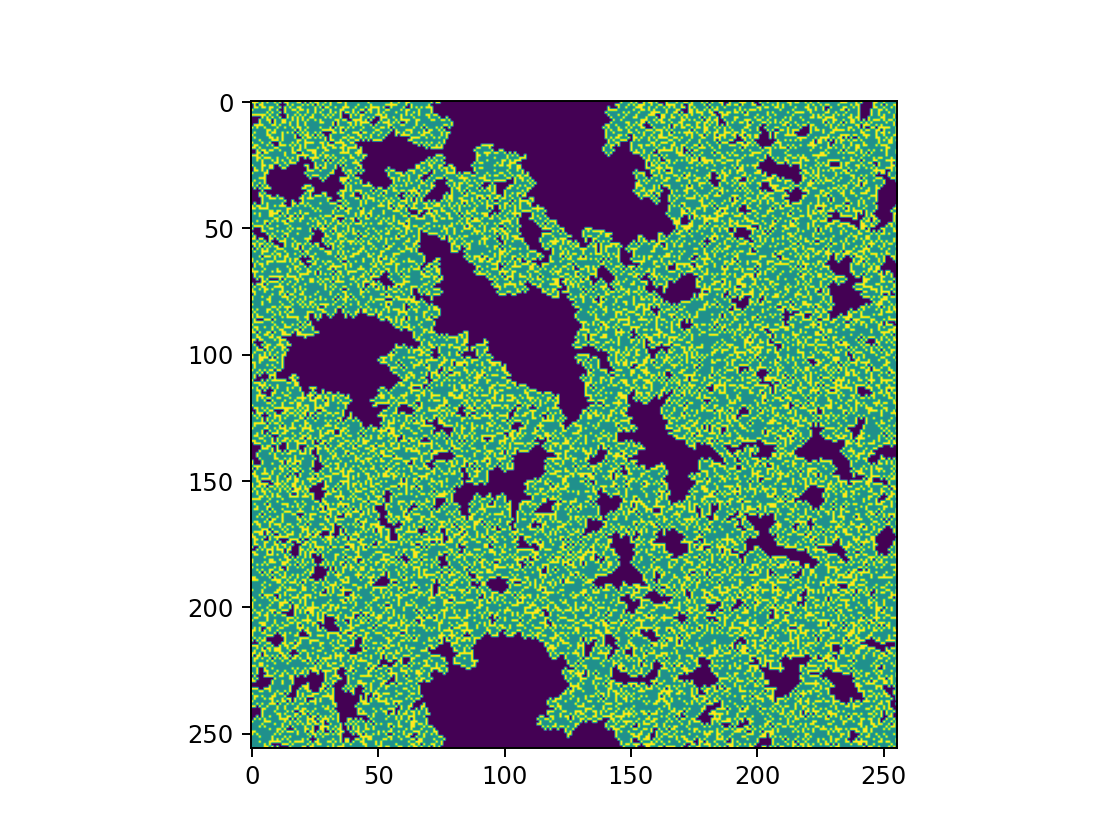

In [242]:
import time
L = 256

lattice = np.zeros((L, L), dtype = int)
xy0 = (int(L/2), int(L/2))

lattice[xy0] = 1

left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
up     = lambda xy: (      xy[0], (xy[1]+1)%L)
down   = lambda xy: (      xy[0], (xy[1]-1)%L)

queue = [(xy0,  left(xy0)), 
         (xy0, right(xy0)), 
         (xy0,    up(xy0)), 
         (xy0,  down(xy0))]

k = 0.43

b = 1

seed = np.random.randint(1000000)
np.random.seed(seed) 

#137117, 112642

SZR = {0:[], 1:[], 2:[]}

start_time = time.time()
while len(queue) != 0:
    
    labels, counts = np.unique(lattice, return_counts = True)
    
    for j in range(len(labels)):
        SZR[labels[j]].append(counts[j])
        
        
    lattice, queue = update(lattice, queue, k, b)

    #for validation
    #if check(lattice, queue) == False:
    #    break
print(time.time() - start_time)       
plt.imshow(lattice)

986.8956632614136


<IPython.core.display.Javascript object>


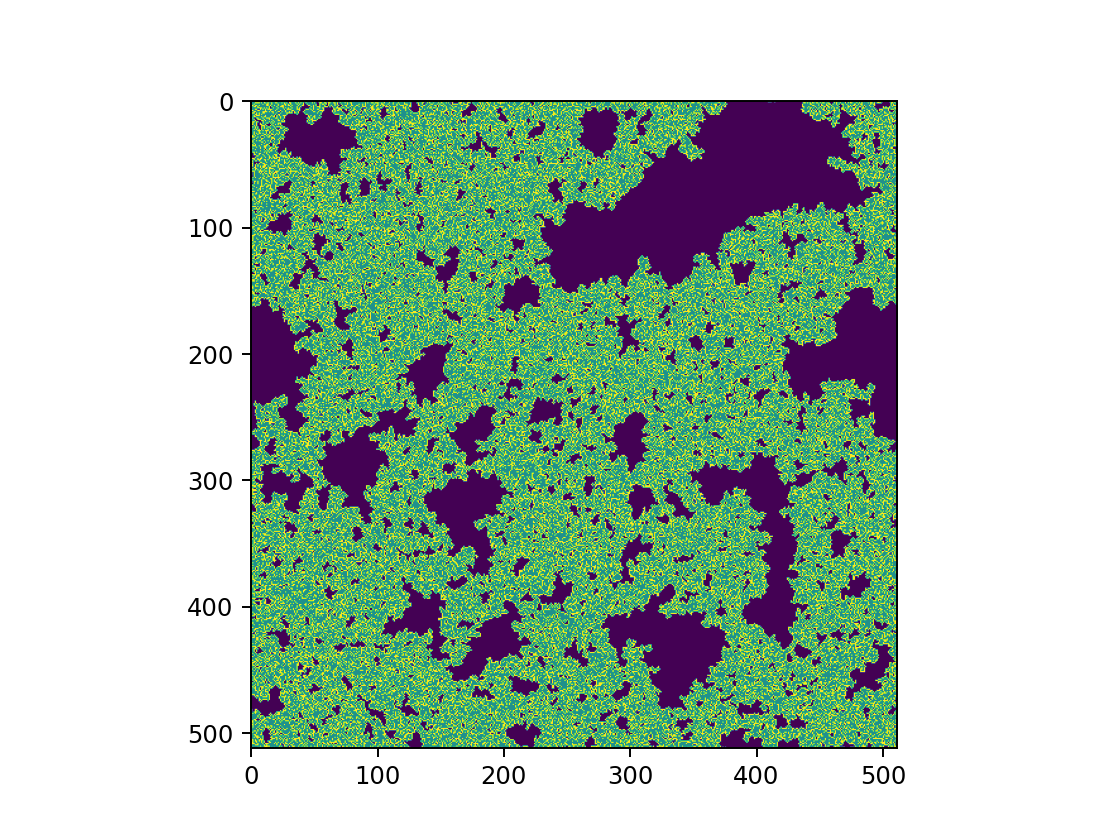

In [243]:
L = 512

lattice = np.zeros((L, L), dtype = int)
xy0 = (int(L/2), int(L/2))

lattice[xy0] = 1

left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
up     = lambda xy: (      xy[0], (xy[1]+1)%L)
down   = lambda xy: (      xy[0], (xy[1]-1)%L)

queue = [(xy0,  left(xy0)), 
         (xy0, right(xy0)), 
         (xy0,    up(xy0)), 
         (xy0,  down(xy0))]

k = 0.43

b = 1

seed = np.random.randint(1000000)
np.random.seed(seed) 

#137117, 112642

SZR = {0:[], 1:[], 2:[]}

start_time = time.time()
while len(queue) != 0:
    
    labels, counts = np.unique(lattice, return_counts = True)
    
    for j in range(len(labels)):
        SZR[labels[j]].append(counts[j])
        
        
    lattice, queue = update(lattice, queue, k, b)

    #for validation
    #if check(lattice, queue) == False:
    #    break
print(time.time() - start_time)       
plt.imshow(lattice)